<a href="https://colab.research.google.com/github/sanxlop/stocks/blob/master/stocks_talib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install yfinance

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf

import talib

%matplotlib inline
plt.style.use('dark_background')

In [0]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

# # Get data from yfinance
# def get_historical_yfinance(tickers):
#     tickers = yf.Tickers(" ".join(tickers.keys()))
#     return tickers.history(period="6mo", interval="1d", start=None, end=None, actions=True, rounding=True)

# # Add extra info
# def set_change_label(x):
#     if x > 0:
#         return 1
#     else:
#         return 0

def add_price_transforms(df):
    for ticker in tickers_desc.keys():
        df[ticker,'CHANGE'] = df[ticker,'Close'].diff()
        df[ticker,'CHANGE_PERCENT'] = df[ticker,'Close'].div(df[ticker,'Close'].shift(1))*100-100
        #df[ticker,'CHANGE_LABEL'] = df[ticker,'CHANGE'].apply(set_change_label)
        df[ticker,'AVGPRICE'] = talib.AVGPRICE(df[ticker,'Open'], df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Average Price
        df[ticker,'MEDPRICE'] = talib.MEDPRICE(df[ticker,'High'], df[ticker,'Low']) # Median Price
        df[ticker,'TYPPRICE'] = talib.TYPPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Typical Price
        df[ticker,'WCLPRICE'] = talib.WCLPRICE(df[ticker,'High'], df[ticker,'Low'], df[ticker,'Close']) # Weighted Close Price
    return df

def add_overlap_functions(df):
    for ticker in tickers_desc.keys():
        df[ticker,'DEMA'] = talib.DEMA(df[ticker,'Close'], timeperiod=30) # Double Exponential Moving Average
        df[ticker,'EMA'] = talib.EMA(df[ticker,'Close'], timeperiod=30) # Exponential Moving Average
        df[ticker,'HT_TRENDLINE'] = talib.HT_TRENDLINE(df[ticker,'Close']) # Hilbert Transform - Instantaneous Trendline
        df[ticker,'KAMA'] = talib.KAMA(df[ticker,'Close'], timeperiod=30) # Kaufman Adaptive Moving Average
        df[ticker,'MA'] = talib.MA(df[ticker,'Close'], timeperiod=30, matype=0) # Moving average
        df[ticker,'MAMA_mama'], df[ticker,'MAMA_fama'] = talib.MAMA(df[ticker,'Close'], fastlimit=0.5, slowlimit=0.05) # MESA Adaptive Moving Average
        #df[ticker,'MAVP'] = talib.MAVP(df[ticker,'Close'], periods, minperiod=2, maxperiod=30, matype=0) # Moving average with variable period
        df[ticker,'MIDPOINT'] = talib.MIDPOINT(df[ticker,'Close'], timeperiod=14) # MidPoint over period
        df[ticker,'MIDPRICE'] = talib.MIDPRICE(df[ticker,'High'], df[ticker,'Low'], timeperiod=14) # Midpoint Price over period
        df[ticker,'SAR'] = talib.SAR(df[ticker,'High'], df[ticker,'Low'], acceleration=0.02, maximum=0.2) # Parabolic SAR
        df[ticker,'SAREXT'] = talib.SAREXT(df[ticker,'High'], df[ticker,'Low'], startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0) # Parabolic SAR - Extended
        df[ticker,'SMA'] = talib.SMA(df[ticker,'Close'], timeperiod=30) # Simple Moving Average
        df[ticker,'T3'] = talib.T3(df[ticker,'Close'], timeperiod=5, vfactor=0.7) # Triple Exponential Moving Average (T3)
        df[ticker,'TEMA'] = talib.TEMA(df[ticker,'Close'], timeperiod=30) # Triple Exponential Moving Average
        df[ticker,'TRIMA'] = talib.TRIMA(df[ticker,'Close'], timeperiod=30) # Triangular Moving Average
        df[ticker,'WMA'] = talib.WMA(df[ticker,'Close'], timeperiod=30) # Weighted Moving Average
    return df

def add_indicators_functions(df, timeperiod, config_limits):
    for ticker in tickers_desc.keys():
        df[ticker,'BB_up'], df[ticker,'BB_mid'], df[ticker,'BB_low'] = talib.BBANDS(df[ticker,'Close'].values, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0) # MA_Type.SMA
        df[ticker,'BBP'] = (df[ticker,'Close'] - df[ticker,'BB_low']) / (df[ticker,'BB_up'] - df[ticker,'BB_low'])
        df[ticker,'RSI'] = talib.RSI(df[ticker,'Close'], timeperiod=timeperiod)
        
        df[ticker,'HOLDINGS'] = 0
        df.loc[((df[ticker,'RSI'] < config_limits.get('RSI_LOW_LIMIT')) & (df[ticker,'BBP'] < config_limits.get('BBP_LOW_LIMIT'))), (ticker,'HOLDINGS')] = df[ticker,'RSI']/100 # + price['BBP'])/2 # + Buy Green
        df.loc[((df[ticker,'RSI'] > config_limits.get('RSI_UP_LIMIT')) & (df[ticker,'BBP'] > config_limits.get('BBP_UP_LIMIT'))), (ticker,'HOLDINGS')] = -(df[ticker,'RSI']/100) # + price['BBP'])/2 # - Sell Red

        df[ticker,'BLOW_SHIGH'] = 0
        df.loc[(df[ticker,'Close'] < calc_num_low(df[ticker,'Close'], config_limits.get('BLOW_SHIGH_LOW'))), (ticker,'BLOW_SHIGH')] = calc_percent_low(df[ticker,'Close']) # + Buy Blue
        df.loc[(df[ticker,'Close'] > calc_num_high(df[ticker,'Close'], config_limits.get('BLOW_SHIGH_UP'))), (ticker,'BLOW_SHIGH')] = -calc_percent_high(df[ticker,'Close']) # - Sell Purple
    return df

def calc_num_low(df_column, percent_thr):
    low_percent = df_column.min() * 100 / df_column.max()
    admit_percent = low_percent + percent_thr
    low_number = df_column.max() * admit_percent / 100
    return low_number

def calc_num_high(df_column, percent_thr):
    high_percent = 100
    admit_percent = high_percent - percent_thr
    high_number = df_column.max() * admit_percent / 100
    return high_number

def calc_percent_low(df_column):
    return df_column.min() / df_column

def calc_percent_high(df_column):
    return df_column / df_column.max()

def plot_result(df, ticker, config_limits, tickers_desc):
    fig, (ax0, ax1, ax3, ax2) = plt.subplots(4, 1, sharex=True, figsize=(12, 12))
    plt.suptitle(ticker+" "+ tickers_desc.get(ticker))
    ax0.plot(df.index, df[ticker,'Close'], label='Close')
    ax0.set_xlabel('Date')
    ax0.set_ylabel('Close')
    ax0.grid()
    for day, holding in df[ticker].iterrows():
        order = holding['HOLDINGS']
        order2 = holding['BLOW_SHIGH']
        if order > 0: # + Buy Green
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='green', alpha=(1-order), s=(1-order)*100)
        elif order < 0: # - Sell Red
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='red', alpha=abs(order), s=abs(order)*100)

        if order2 > 0: # + Buy Blue
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='blue', alpha=1)
        elif order2 < 0: # - Sell Purple
            ax0.scatter(x=day, y=df.loc[day, (ticker,'Close')], color='purple', alpha=1)

    ax1.plot(df.index, df[ticker,'RSI'], label='RSI')
    ax1.fill_between(df.index, y1=config_limits.get('RSI_LOW_LIMIT'), y2=config_limits.get('RSI_UP_LIMIT'), color='#adccff', alpha=0.3)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('RSI')
    ax1.grid()

    ax3.plot(df.index, df[ticker,'BBP'], label='BBP')
    ax3.fill_between(df.index, y1=config_limits.get('BBP_LOW_LIMIT'), y2=config_limits.get('BBP_UP_LIMIT'), color='#adccff', alpha=0.3)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('BBP')
    ax3.grid()

    ax2.plot(df.index, df[ticker,'BB_up'], label='BB_up')
    ax2.plot(df.index, df[ticker,'Close'], label='Close')
    ax2.plot(df.index, df[ticker,'BB_low'], label='BB_low')
    ax2.fill_between(df.index, y1=df[ticker,'BB_low'], y2=df[ticker,'BB_up'], color='#adccff', alpha=0.3)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Bollinger Bands')
    ax2.grid()

    fig.tight_layout()
    plt.show()

In [0]:
tickers_desc = {'ACN': 'Accenture',
                'ATVI': 'Activision',
                'ADS': 'Adidas',
                'ADBE': 'Adobe_Inc',
                'BABA': 'Alibaba',
                'GOOG': 'Alphabet',
                'AMZN': 'Amazon.com',
                'AMD': 'AMD',
                'AAPL': 'Apple',
                'ASTC': 'Astrotech',
                'T': 'AT&T',
                'BIDU': 'Baidu',
                'SAN': 'Banco_Santander',
                'BBVA': 'BBVA',
                'BB': 'Blackberry',
                'BKNG': 'Booking_Holdings',
                'BP': 'BP',
                'CAIXY': 'Caixabank',
                'CHFS': 'CHF_Solutions',
                'CSCO': 'Cisco_Systems',
                'KO': 'Coca-Cola',
                'CCEP': 'Coca-Cola_Euro',
                'DPZ': 'Dominos_Piza',
                'EA': 'Electronic_Arts',
                'ERIC': 'Ericsson',
                'FB': 'Facebook',
                'F': 'Ford_Motor',
                'GE': 'GE',
                'IDEXY': 'Inditex',
                'INTC': 'Intel',
                'JPM': 'JPMorgan',
                'MA': 'Mastercard',
                'MCD': 'McDonalds',
                'MU': 'Micron_Tech',
                'MSFT': 'Microsoft',
                'NFLX': 'Netflix',
                'NKE': 'Nike',
                'NVDA': 'Nvidia',
                'ORCL': 'Oracle',
                'ORAN': 'Orange',
                'PYPL': 'PayPal',
                'PEP': 'PepsiCo',
                'PFE': 'Pfizer',
                'QCOM': 'Qualcomm',
                'RYAAY': 'Ryanair',
                'SNE': 'Sony',
                'SPOT': 'Spotify',
                'TEF': 'Telefonica',
                'TERP': 'TerraForm_Power',
                'TSLA': 'TESLA',
                'TM': 'Toyota',
                'TWTR': 'Twitter',           
                'UBER': 'Uber',
                'VRTX': 'Vertex_Pharmaceuticals',
                'VZ': 'Verizon',
                'V': 'Visa',
                'VOD': 'Vodafone_Group',
                'DIS': 'Walt_Disnet',
                'XIACY': 'XIAOMI',
                'ZM': 'ZOOM VIDEO',
              }
tickers_names = " ".join(tickers_desc.keys())


config_limits = {'RSI_LOW_LIMIT': 30,
                  'RSI_UP_LIMIT': 70,
                  'BBP_LOW_LIMIT': 0,
                  'BBP_UP_LIMIT': 1,
                  'BLOW_SHIGH_LOW': 2,
                  'BLOW_SHIGH_UP': 2,
                 }

In [30]:
"""Get data from yfinance"""
print(tickers_names)
hist_downloaded = yf.download(tickers_names, period="1y", interval="1d", start=None, end=None, actions=False, rounding=True, group_by='ticker', threads=True)

ACN ATVI ADS ADBE BABA GOOG AMZN AMD AAPL ASTC T BIDU SAN BBVA BB BKNG BP CAIXY CHFS CSCO KO CCEP DPZ EA ERIC FB F GE IDEXY INTC JPM MA MCD MU MSFT NFLX NKE NVDA ORCL ORAN PYPL PEP PFE QCOM RYAAY SNE SPOT TEF TERP TSLA TM TWTR UBER VRTX VZ V VOD DIS XIACY ZM
[*********************100%***********************]  60 of 60 completed


In [0]:
"""Add extra info"""
hist = hist_downloaded
hist = add_price_transforms(df=hist)
hist = add_overlap_functions(df=hist)
hist = add_indicators_functions(df=hist, timeperiod=14, config_limits=config_limits)
# display(hist[['GOOG']].head(1))
# display(hist[['GOOG']].tail(1))

Date
2019-11-01   -0.982841
2019-11-04   -0.981327
2019-11-05   -0.988393
2019-11-06   -0.990411
2019-11-07   -0.994701
2019-11-08   -0.993692
2019-11-11   -0.993439
2019-11-12   -0.988393
2019-11-13   -0.988140
2019-11-14   -0.982841
2019-11-15   -0.996720
2019-11-18   -1.000000
2019-12-19   -0.982337
2019-12-20   -0.987888
2019-12-23   -0.985869
2019-12-24   -0.983094
2019-12-26   -0.988140
2019-12-27   -0.990159
2019-12-30   -0.985112
2019-12-31   -0.986122
2020-01-02   -0.980570
2020-01-03   -0.985617
2020-01-06   -0.986626
2020-01-07   -0.990411
2020-01-08   -0.993439
2020-01-22   -0.985112
2020-03-23    1.000000
2020-04-03    0.974873
Name: (T, BLOW_SHIGH), dtype: float64

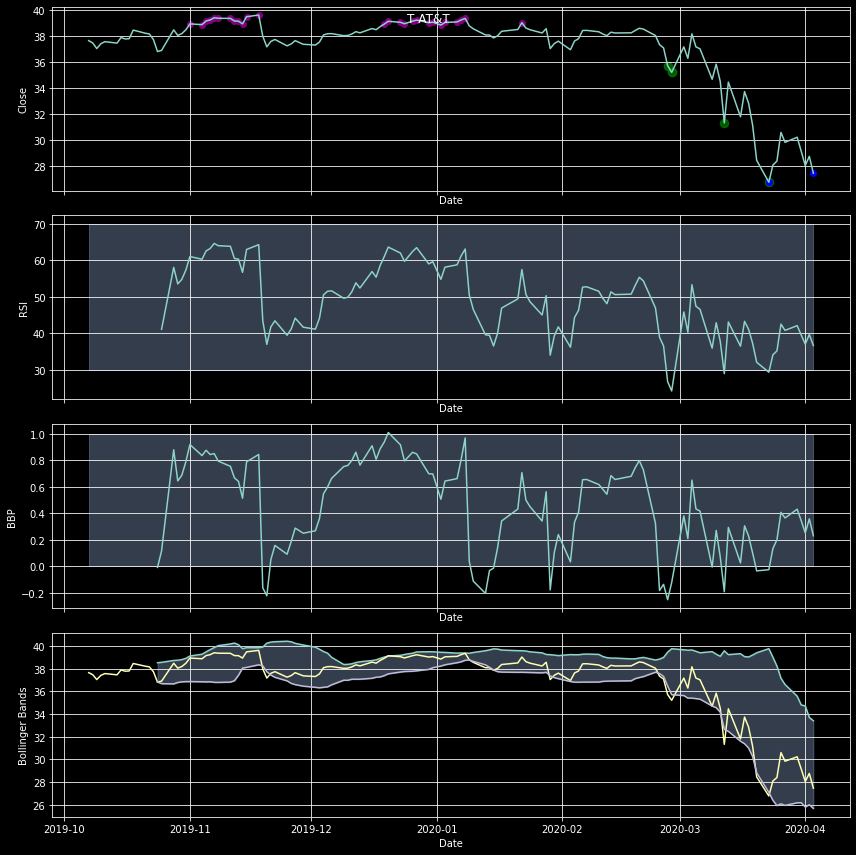

Date
2019-10-21   -0.988636
2019-10-22   -0.990909
2019-10-23   -1.000000
2019-10-24   -0.988636
2019-10-25   -0.993182
2019-10-28   -0.993182
2019-10-29   -0.986364
2020-01-02   -0.981818
2020-03-16    0.981818
2020-03-18    1.000000
2020-03-19    0.990826
2020-03-20    0.986301
2020-04-03    0.968610
Name: (SAN, BLOW_SHIGH), dtype: float64

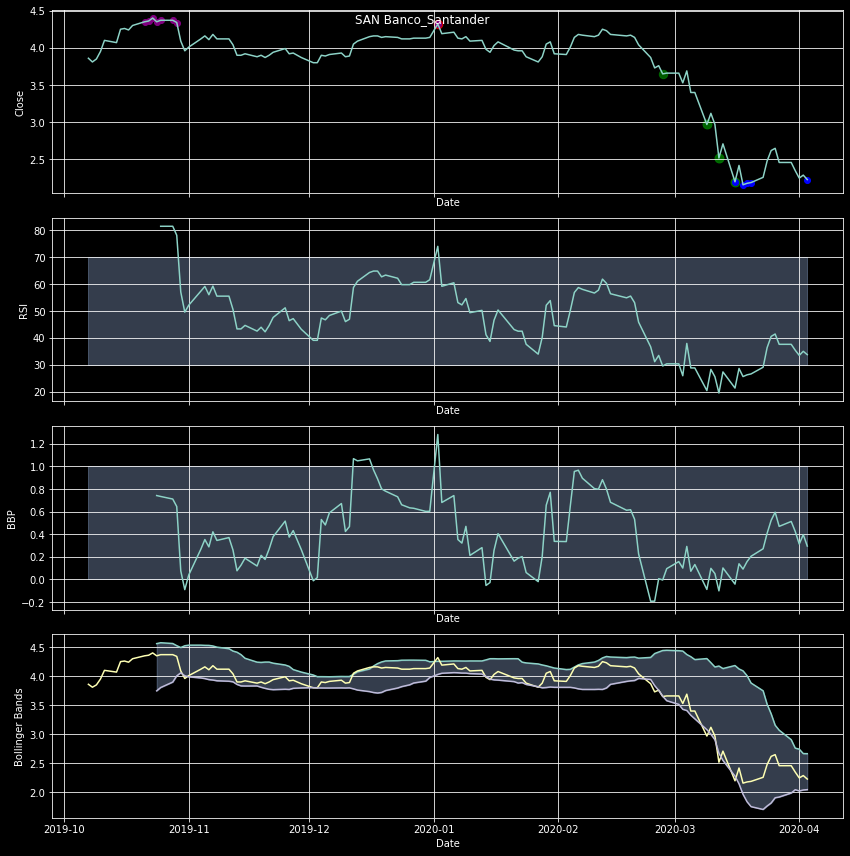

Date
2020-01-02   -0.986207
2020-02-10   -0.981034
2020-02-11   -0.982759
2020-02-12   -1.000000
2020-02-13   -0.984483
2020-03-16    0.986159
2020-03-18    0.962838
2020-04-01    0.982759
2020-04-02    1.000000
2020-04-03    0.972696
Name: (BBVA, BLOW_SHIGH), dtype: float64

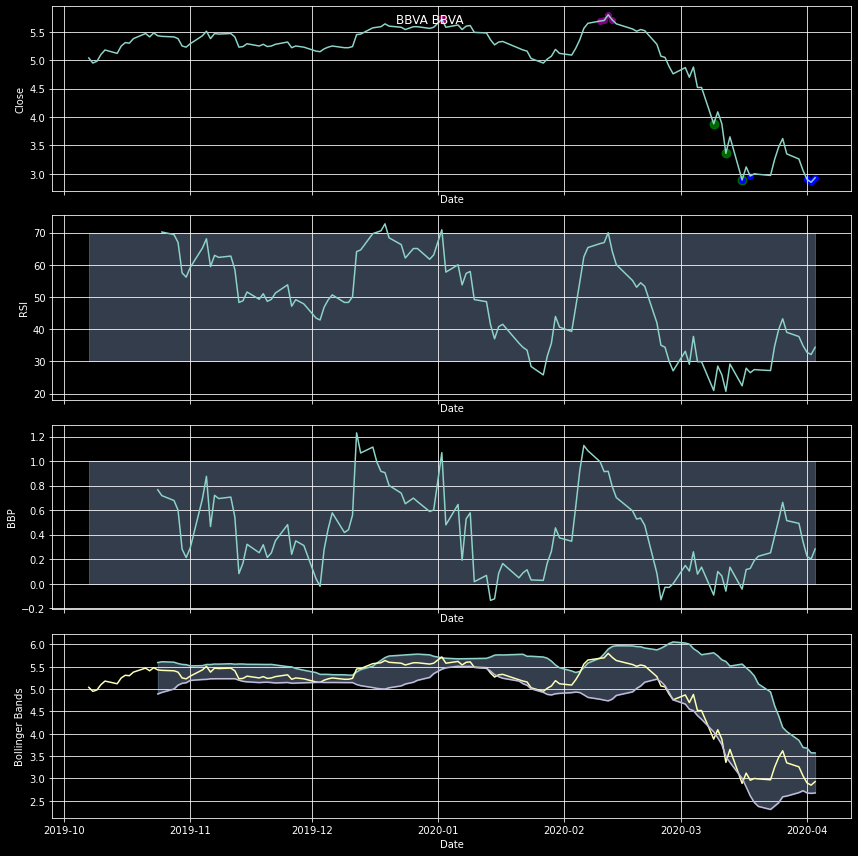

Date
2020-01-02   -0.992823
2020-01-03   -0.985646
2020-02-06   -0.980861
2020-02-10   -1.000000
2020-02-12   -0.980861
2020-03-16    0.973916
2020-03-18    0.975931
2020-03-20    0.969550
2020-03-23    0.993301
2020-04-02    0.970093
2020-04-03    1.000000
Name: (CAIXY, BLOW_SHIGH), dtype: float64

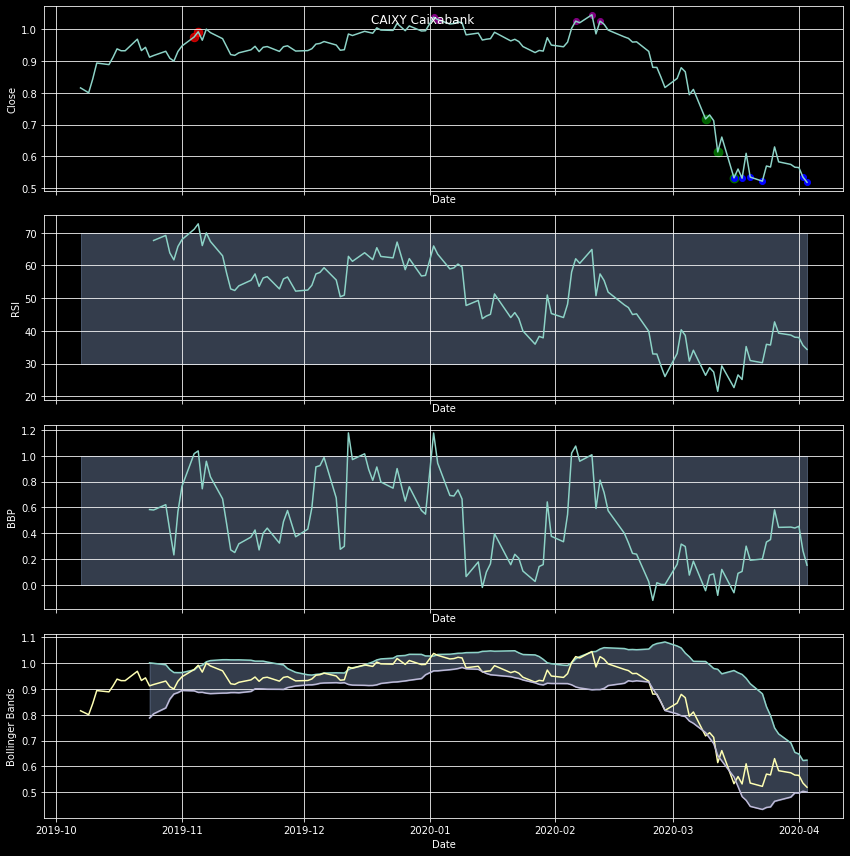

['T', 'SAN', 'BBVA', 'CAIXY']


In [7]:
"""Display results"""
interesting_labels = []
for tick in tickers_desc.keys():
    bl = hist[tick, 'BLOW_SHIGH']
    filter_bl = bl.tail(3)
    if filter_bl.any() != 0:
        display(bl[bl != 0])
        interesting_labels.append(tick)
        plot_result(df=hist, ticker=tick, config_limits=config_limits, tickers_desc=tickers_desc)
print(interesting_labels)

In [0]:
# # Show overlap functions
# overlap_functions = ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_mama', 'MAMA_fama', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA']
# for func in overlap_functions:
#     plt.figure(figsize=(14,4))
#     plt.title(func)
#     plt.grid()
#     plt.plot(hist['ASTC', func])
#     plt.plot(hist['ASTC', 'Close'])
#     # Show/save figure as desired.
#     plt.show()

In [0]:
# from talib import CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS

# patterns = [CDL2CROWS, CDL3BLACKCROWS, CDL3INSIDE, CDL3LINESTRIKE, CDL3OUTSIDE, CDL3STARSINSOUTH, CDL3WHITESOLDIERS, CDLABANDONEDBABY, CDLADVANCEBLOCK, CDLBELTHOLD, CDLBREAKAWAY, CDLCLOSINGMARUBOZU, CDLCONCEALBABYSWALL, CDLCOUNTERATTACK, CDLDARKCLOUDCOVER, CDLDOJI, CDLDOJISTAR, CDLDRAGONFLYDOJI, CDLENGULFING, CDLEVENINGDOJISTAR, CDLEVENINGSTAR, CDLGAPSIDESIDEWHITE, CDLGRAVESTONEDOJI, CDLHAMMER, CDLHANGINGMAN, CDLHARAMI, CDLHARAMICROSS, CDLHIGHWAVE, CDLHIKKAKE, CDLHIKKAKEMOD, CDLHOMINGPIGEON, CDLIDENTICAL3CROWS, CDLINNECK, CDLINVERTEDHAMMER, CDLKICKING, CDLKICKINGBYLENGTH, CDLLADDERBOTTOM, CDLLONGLEGGEDDOJI, CDLLONGLINE, CDLMARUBOZU, CDLMATCHINGLOW, CDLMATHOLD, CDLMORNINGDOJISTAR, CDLMORNINGSTAR, CDLONNECK, CDLPIERCING, CDLRICKSHAWMAN, CDLRISEFALL3METHODS, CDLSEPARATINGLINES, CDLSHOOTINGSTAR, CDLSHORTLINE, CDLSPINNINGTOP, CDLSTALLEDPATTERN, CDLSTICKSANDWICH, CDLTAKURI, CDLTASUKIGAP, CDLTHRUSTING, CDLTRISTAR, CDLUNIQUE3RIVER, CDLUPSIDEGAP2CROWS, CDLXSIDEGAP3METHODS]
# patterns_names = ['CDL2CROWS - Two Crows', 'CDL3BLACKCROWS - Three Black Crows', 'CDL3INSIDE - Three Inside Up/Down', 'CDL3LINESTRIKE - Three-Line Strike', 'CDL3OUTSIDE - Three Outside Up/Down', 'CDL3STARSINSOUTH - Three Stars In The South', 'CDL3WHITESOLDIERS - Three Advancing White Soldiers', 'CDLABANDONEDBABY - Abandoned Baby', 'CDLADVANCEBLOCK - Advance Block', 'CDLBELTHOLD - Belt-hold', 'CDLBREAKAWAY - Breakaway', 'CDLCLOSINGMARUBOZU - Closing Marubozu', 'CDLCONCEALBABYSWALL - Concealing Baby Swallow', 'CDLCOUNTERATTACK - Counterattack', 'CDLDARKCLOUDCOVER - Dark Cloud Cover', 'CDLDOJI - Doji', 'CDLDOJISTAR - Doji Star', 'CDLDRAGONFLYDOJI - Dragonfly Doji', 'CDLENGULFING - Engulfing Pattern', 'CDLEVENINGDOJISTAR - Evening Doji Star', 'CDLEVENINGSTAR - Evening Star', 'CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines', 'CDLGRAVESTONEDOJI - Gravestone Doji', 'CDLHAMMER - Hammer', 'CDLHANGINGMAN - Hanging Man', 'CDLHARAMI - Harami Pattern', 'CDLHARAMICROSS - Harami Cross Pattern', 'CDLHIGHWAVE - High-Wave Candle', 'CDLHIKKAKE - Hikkake Pattern', 'CDLHIKKAKEMOD - Modified Hikkake Pattern', 'CDLHOMINGPIGEON - Homing Pigeon', 'CDLIDENTICAL3CROWS - Identical Three Crows', 'CDLINNECK - In-Neck Pattern', 'CDLINVERTEDHAMMER - Inverted Hammer', 'CDLKICKING - Kicking', 'CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu', 'CDLLADDERBOTTOM - Ladder Bottom', 'CDLLONGLEGGEDDOJI - Long Legged Doji', 'CDLLONGLINE - Long Line Candle', 'CDLMARUBOZU - Marubozu', 'CDLMATCHINGLOW - Matching Low', 'CDLMATHOLD - Mat Hold', 'CDLMORNINGDOJISTAR - Morning Doji Star', 'CDLMORNINGSTAR - Morning Star', 'CDLONNECK - On-Neck Pattern', 'CDLPIERCING - Piercing Pattern', 'CDLRICKSHAWMAN - Rickshaw Man', 'CDLRISEFALL3METHODS - Rising/Falling Three Methods', 'CDLSEPARATINGLINES - Separating Lines', 'CDLSHOOTINGSTAR - Shooting Star', 'CDLSHORTLINE - Short Line Candle', 'CDLSPINNINGTOP - Spinning Top', 'CDLSTALLEDPATTERN - Stalled Pattern', 'CDLSTICKSANDWICH - Stick Sandwich', 'CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)', 'CDLTASUKIGAP - Tasuki Gap', 'CDLTHRUSTING - Thrusting Pattern', 'CDLTRISTAR - Tristar Pattern', 'CDLUNIQUE3RIVER - Unique 3 River', 'CDLUPSIDEGAP2CROWS - Upside Gap Two Crows', 'CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Method']

# for patt, patt_name in zip(patterns, patterns_names):
#     integer = patt(hist['Open', stock_symbol], 
#                     hist['High', stock_symbol], 
#                     hist['Low', stock_symbol], 
#                     hist['Close', stock_symbol])
#     if len(integer.tail(2).unique()) > 1:
#         print(patt_name)
#         print(integer.tail(2))

In [0]:
# import talib

# print(talib.get_functions())

# for key,value in talib.get_function_groups().items():
#   print(key,value)

# LSTM

In [32]:
hist.tail(3)

UBER                       ...        ZM                               
             Open   High    Low  Close  ...       BBP        RSI HOLDINGS BLOW_SHIGH
Date                                    ...                                         
2020-04-01  26.50  26.77  24.81  25.42  ...  0.564471  57.443722      0.0        0.0
2020-04-02  25.01  25.20  23.00  23.68  ...  0.302610  48.654244      0.0        0.0
2020-04-03  23.73  23.79  21.67  22.82  ...  0.367700  51.948565      0.0        0.0

[3 rows x 2100 columns]

In [0]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
import tensorflow as tf
# from keras.models import Sequential, load_model
# from keras.layers import Dense, Dropout
# from keras.layers import LSTM
# from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
# from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# import talos as ta

In [121]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Europe/Spain'  # to set timezone; needed when running on cloud
time.tzset()

params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 30
}

iter_changes = "dropout_layers_0.4_0.4"

PATH_TO_DRIVE_ML_DATA = "/content"
INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/inputs"
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"/outputs/lstm_best_7-3-19_12AM/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    print("Directory already exists. Don't override.")

def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")

def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    print("Look TIME_STEPS", mat.shape[0], '>', TIME_STEPS)
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    print(dim_0, dim_1)
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("build_timeseries: length of time-series i/o",x.shape,y.shape)
    return x, y

def create_model():
    lstm_model = tf.keras.models.Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(tf.keras.layers.LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(tf.keras.layers.Dropout(0.4))
    lstm_model.add(tf.keras.layers.LSTM(60, dropout=0.0))
    lstm_model.add(tf.keras.layers.Dropout(0.4))
    lstm_model.add(tf.keras.layers.Dense(20,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    optimizer = tf.keras.optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

Directory already exists. Don't override.


In [129]:
train_cols = ["Open","High","Low","Close","Volume"]
ticker = 'BBVA'

stime = time.time()

df_predict = hist[ticker]

print('df_predict')
print('Shape:', df_predict.shape)
print('Columns:', df_predict.columns)

df_train, df_test = train_test_split(df_predict, train_size=0.7, test_size=0.3, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

del df_test
del df_train
del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
print("\n --> TRAIN TIMESERIES\n")
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size x and y",x_t.shape, y_t.shape)


model = None
try:
    model = pickle.load(open(PATH_TO_DRIVE_ML_DATA+"/lstm_model.pickle", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")

print("\n --> TEST VALIDATION TIMESERIES\n")
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size (x,y);", x_test_t.shape, y_test_t.shape, "\nVal size (x,y):", x_val.shape, y_val.shape)

df_predict
Shape: (251, 35)
Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'CHANGE',
       'CHANGE_PERCENT', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE',
       'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA_mama', 'MAMA_fama',
       'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA',
       'WMA', 'BB_up', 'BB_mid', 'BB_low', 'BBP', 'RSI', 'HOLDINGS',
       'BLOW_SHIGH'],
      dtype='object')
Train and Test size 175 76
Are any NaNs present in train/test matrices? False False

 --> TRAIN TIMESERIES

Look TIME_STEPS 175 > 30
145 5
dim_0 145



build_timeseries: length of time-series i/o (145, 30, 5) (145,)
Batch trimmed size x and y (140, 30, 5) (140,)
Model not found

 --> TEST VALIDATION TIMESERIES

Look TIME_STEPS 76 > 30
46 5
dim_0 46



build_timeseries: length of time-series i/o (46, 30, 5) (46,)
Test size (x,y); (20, 30, 5) (20,) 
Val size (x,y): (20, 30, 5) (20,)


In [127]:
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    #print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = tf.keras.callbacks.ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    validation_data_x = trim_dataset(x_val, BATCH_SIZE)
    validation_data_y = trim_dataset(y_val, BATCH_SIZE)
    history = model.fit(x_t, y_t, 
                        epochs=params["epochs"], 
                        verbose=2, 
                        batch_size=BATCH_SIZE,
                        shuffle=False, 
                        validation_data=(validation_data_x, trim_dataset(y_val, BATCH_SIZE)), 
                        callbacks=[es, mcp, csv_logger]
                        )
    
    print("saving model...")
    #pickle.dump(model, open(PATH_TO_DRIVE_ML_DATA+"/lstm_model.pickle", "wb"))

Building model...
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.07057, saving model to /content/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
7/7 - 1s - loss: 0.0545 - val_loss: 0.0706
Epoch 2/300

Epoch 00002: val_loss improved from 0.07057 to 0.06646, saving model to /content/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
7/7 - 0s - loss: 0.0474 - val_loss: 0.0665
Epoch 3/300

Epoch 00003: val_loss improved from 0.06646 to 0.06437, saving model to /content/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
7/7 - 0s - loss: 0.0440 - val_loss: 0.0644
Epoch 4/300

Epoch 00004: val_loss improved from 0.06437 to 0.06393, saving model to /content/outputs/lstm_best_7-3-19_12AM/dropout_layers_0.4_0.4/best_model.h5
7/7 - 0s - loss: 0.0401 - val_loss: 0.0639
Epoch 5/300

Epoch 00005: val_loss did not improve from 0.06393
7/7 - 0s - loss: 0.0393 - val_loss: 0.0643
Epoch 6/300

Epoch 00006: val_loss did not improve from 0.06393

Error is 0.06424096754096494 (20,) (20,)
[0.64581674 0.646092   0.64655954 0.64575845 0.6435882  0.6410693
 0.6395674  0.6387036  0.6381997  0.6377086  0.6377715  0.6388723
 0.6404404  0.64193165 0.6432883 ]
[ 0.13142857  0.81428571  0.00857143 -0.01428571  0.70857143  0.65142857
  0.76        0.70571429  0.76        0.73142857  0.75714286  0.76857143
  0.63142857  0.59428571  0.67142857]
[5.1603584 5.161322  5.162958  5.1601543 5.152559  5.1437426 5.138486
 5.1354628 5.133699  5.13198   5.1322002 5.136053  5.1415415 5.146761
 5.1515093]
[3.36 5.75 2.93 2.85 5.38 5.18 5.56 5.37 5.56 5.46 5.55 5.59 5.11 4.98
 5.25]
Error is 0.063540587249941 (20,) (20,)
[0.61754566 0.61783886 0.6183628  0.6178056  0.6160086  0.61433893
 0.6129698  0.6120323  0.6113956  0.6112623  0.61148083 0.6120951
 0.61317366 0.61430633 0.6153342 ]
[ 0.13142857  0.81428571  0.00857143 -0.01428571  0.70857143  0.65142857
  0.76        0.70571429  0.76        0.73142857  0.75714286  0.76857143
  0.63142857  0.59428571 

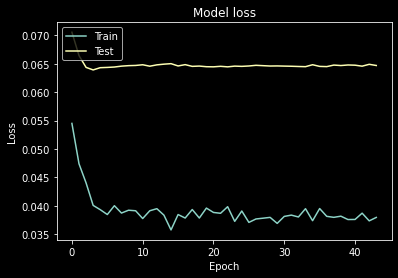

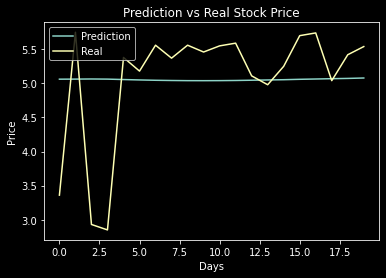

In [128]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
saved_model = tf.keras.models.load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)